# 1. Collect Dataset Sample

In [4]:
def enhance_image(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)


In [5]:
import cv2
import os

def extract_frames(video_path, output_folder, frame_skip=5):
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)

    frame_id = 0
    saved_id = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_id % frame_skip == 0:
            out_path = os.path.join(output_folder, f"frame_{saved_id}.jpg")
            frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
            frame = enhance_image(frame)
            cv2.imwrite(out_path, frame)
            saved_id += 1

        frame_id += 1

    cap.release()
    print(f"✅ Saved {saved_id} frames from {video_path} into {output_folder}")


In [3]:
extract_frames("./raw_videos/M.mp4" , "./raw_images/MAHARSHI")

✅ Saved 128 frames from ./raw_videos/M.mp4 into ./raw_images/MAHARSHI


In [4]:
extract_frames("./raw_videos/R.mp4" , "./raw_images/RIDDHI")

✅ Saved 136 frames from ./raw_videos/R.mp4 into ./raw_images/RIDDHI


In [5]:
extract_frames("./raw_videos/S.mp4" , "./raw_images/SHUBHAM")

✅ Saved 132 frames from ./raw_videos/S.mp4 into ./raw_images/SHUBHAM


# 2. Process The Samples

In [6]:
import cv2
import numpy as np

def align_face_with_kps(img, kps, output_size=(112, 112)):
    if kps is None or len(kps) != 5:
        print("❌ Invalid keypoints for alignment")
        return None

    # Standard 5-point reference from ArcFace
    src = np.array([
        [38.2946, 51.6963],
        [73.5318, 51.5014],
        [56.0252, 71.7366],
        [41.5493, 92.3655],
        [70.7299, 92.2041]
    ], dtype=np.float32)

    dst = np.array(kps, dtype=np.float32)

    # Estimate affine transform
    M, _ = cv2.estimateAffinePartial2D(dst, src, method=cv2.LMEDS)

    if M is None:
        print("❌ Alignment matrix calculation failed.")
        return None

    aligned_face = cv2.warpAffine(img, M, output_size, borderValue=0.0)
    return aligned_face


In [7]:
import cv2
import os
from insightface.app import FaceAnalysis

def process_and_save_faces(
    input_folder: str = "./raw_images",
    output_folder: str = "./dataset",
    img_size: tuple = (112, 112)
):
    """
    Detects and aligns faces using RetinaFace (InsightFace),
    resizes to 112x112, and saves to dataset/person_name/*.jpg

    Args:
        input_folder (str): Path to raw images grouped in person folders
        output_folder (str): Where processed aligned face images are saved
        img_size (tuple): Final image size (112x112 recommended)
    """

    # Initialize RetinaFace
    detector = FaceAnalysis( name="buffalo_l",
    allowed_modules=["detection", "landmark", "recognition"],
    providers=["CPUExecutionProvider"])
    detector.prepare(ctx_id=-1)

    # Loop through each person/class
    for person_name in os.listdir(input_folder):
        person_input_path = os.path.join(input_folder, person_name)
        if not os.path.isdir(person_input_path):
            continue

        person_output_path = os.path.join(output_folder, person_name)
        os.makedirs(person_output_path, exist_ok=True)

        print(f"\n🢍 Processing: {person_name}")
        count = 0

        for filename in os.listdir(person_input_path):
            file_path = os.path.join(person_input_path, filename)
            img = cv2.imread(file_path)

            if img is None:
                print(f"❌ Could not load image: {filename}")
                continue

            faces = detector.get(img)

            if not faces:
                print(f"⚠️ No face found in: {filename}")
                continue

            face = faces[0]
            aligned = align_face_with_kps(img, face.kps)


            if aligned is None or aligned.size == 0:
                print(f"⚠️ Aligned crop failed for: {filename} — trying bounding box fallback")

                # Fallback to bounding box crop
                bbox = face.bbox.astype(int)
                x1 = max(bbox[0], 0)
                y1 = max(bbox[1], 0)
                x2 = min(bbox[2], img.shape[1])
                y2 = min(bbox[3], img.shape[0])

                # Validate bounding box dimensions
                if x2 <= x1 or y2 <= y1:
                    print(f"❌ Invalid bbox for: {filename}")
                    continue

                aligned = img[y1:y2, x1:x2]

                if aligned is None or aligned.size == 0:
                    print(f"❌ Even bounding box crop failed for: {filename}")
                    continue

            # Resize to 112x112
            resized = cv2.resize(aligned, img_size)

            save_path = os.path.join(person_output_path, f"{person_name}_{count}.jpg")
            cv2.imwrite(save_path, resized)
            count += 1

        print(f"✅ Saved {count} aligned faces to: {person_output_path}")


In [8]:
process_and_save_faces()

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\Kavita/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\Kavita/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Kavita/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\Kavita/.insightface\models\buffalo_l\genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Kavita/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)

🢍 Processing: MAHARSHI
✅ Saved 136 aligned 

# 3. Generate Embeddings

In [8]:
import numpy as np
import os
import cv2
from insightface.model_zoo import ArcFaceONNX

# Load ArcFace model
model = ArcFaceONNX(model_file="./models/model.onnx")
model.prepare(ctx_id=-1)

def extract_and_save_embeddings(data_dir="./dataset", save_dir="./trained_xy"):
    X = []
    y = []

    os.makedirs(save_dir, exist_ok=True)

    for person_name in os.listdir(data_dir):
        person_path = os.path.join(data_dir, person_name)
        if not os.path.isdir(person_path):
            continue

        for filename in os.listdir(person_path):
            img_path = os.path.join(person_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.resize(img, (112, 112))
            embedding = model.get_feat(img)
            X.append(embedding)
            y.append(person_name)

    X = np.array(X)
    y = np.array(y)
    if len(X.shape) == 3:
        X = X.reshape((X.shape[0], -1))
        
    # Save to disk
    np.save(os.path.join(save_dir, "X_embeddings.npy"), X)
    np.save(os.path.join(save_dir, "y_labels.npy"), y)
    print(f"✅ Saved {len(X)} embeddings to {save_dir}")


In [10]:
extract_and_save_embeddings()

✅ Saved 401 embeddings to ./trained_xy


In [ ]:
# Load saved .npy files
X = np.load("./trained_xy/X_embeddings.npy")  # Shape: (num_samples, 512)
y = np.load("./trained_xy/y_labels.npy")      # Shape: (num_samples,)

In [12]:
print(X.shape)
print(y.shape)

(401, 512)
(401,)


# 4. Train Model

In [13]:
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


# Encode string labels (names) into integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into train/test (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Train SVM classifier
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


# 5. Evaluate Model 

In [14]:
# Evaluate on test set

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"✅ Test Accuracy: {acc*100:.2f}%")

# Detailed classification report
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


✅ Test Accuracy: 97.53%

📊 Classification Report:

              precision    recall  f1-score   support

    MAHARSHI       1.00      0.93      0.96        27
      RIDDHI       0.93      1.00      0.96        27
     SHUBHAM       1.00      1.00      1.00        27

    accuracy                           0.98        81
   macro avg       0.98      0.98      0.98        81
weighted avg       0.98      0.98      0.98        81



# 6. Save Model

In [2]:
# Save model and label encoder
import joblib
joblib.dump(clf, "./models/svm_classifier.joblib")
joblib.dump(le, "./models/label_encoder.joblib")
print("💾 Saved model and label encoder to ./model/")


NameError: name 'clf' is not defined

# 7. Predict Model 

In [14]:
extract_frames("./raw_videos/Stest.mp4" , "./test/raw_images/MAHARSHI")

✅ Saved 131 frames from ./raw_videos/Stest.mp4 into ./test/raw_images/MAHARSHI


In [15]:
process_and_save_faces("./test/raw_images","./test/dataset")

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\Kavita/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\Kavita/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Kavita/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\Kavita/.insightface\models\buffalo_l\genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Kavita/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)

🢍 Processing: MAHARSHI
⚠️ No face found in:

In [16]:
extract_and_save_embeddings(data_dir="./test/dataset", save_dir="./test/trained_xy")

✅ Saved 127 embeddings to ./test/trained_xy


In [17]:
import numpy as np
import joblib

# Step 1: Load the test embeddings
X_test = np.load("./test/trained_xy/X_embeddings.npy")

# Step 2: Load the saved model and label encoder
clf = joblib.load("./models/svm_classifier.joblib")
le = joblib.load("./models/label_encoder.joblib")

# Step 3: Predict
predictions = clf.predict(X_test)
names = le.inverse_transform(predictions)

# Step 4: Show Results
for i, name in enumerate(names):
    print(f"🧠 Sample {i}: Predicted identity → {name}")


🧠 Sample 0: Predicted identity → SHUBHAM
🧠 Sample 1: Predicted identity → SHUBHAM
🧠 Sample 2: Predicted identity → SHUBHAM
🧠 Sample 3: Predicted identity → SHUBHAM
🧠 Sample 4: Predicted identity → SHUBHAM
🧠 Sample 5: Predicted identity → SHUBHAM
🧠 Sample 6: Predicted identity → SHUBHAM
🧠 Sample 7: Predicted identity → SHUBHAM
🧠 Sample 8: Predicted identity → SHUBHAM
🧠 Sample 9: Predicted identity → SHUBHAM
🧠 Sample 10: Predicted identity → SHUBHAM
🧠 Sample 11: Predicted identity → SHUBHAM
🧠 Sample 12: Predicted identity → SHUBHAM
🧠 Sample 13: Predicted identity → SHUBHAM
🧠 Sample 14: Predicted identity → SHUBHAM
🧠 Sample 15: Predicted identity → SHUBHAM
🧠 Sample 16: Predicted identity → SHUBHAM
🧠 Sample 17: Predicted identity → SHUBHAM
🧠 Sample 18: Predicted identity → SHUBHAM
🧠 Sample 19: Predicted identity → SHUBHAM
🧠 Sample 20: Predicted identity → SHUBHAM
🧠 Sample 21: Predicted identity → SHUBHAM
🧠 Sample 22: Predicted identity → SHUBHAM
🧠 Sample 23: Predicted identity → SHUBHAM
🧠 

✅ Test Accuracy: 97.53%

📊 Classification Report:
              precision    recall  f1-score   support

    MAHARSHI       1.00      0.93      0.96        27
      RIDDHI       0.93      1.00      0.96        27
     SHUBHAM       1.00      1.00      1.00        27

    accuracy                           0.98        81
   macro avg       0.98      0.98      0.98        81
weighted avg       0.98      0.98      0.98        81



<Figure size 800x600 with 0 Axes>

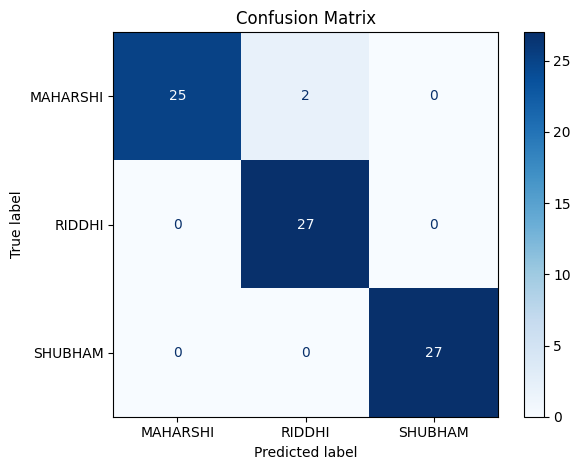

In [6]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

# ----------------------------------------------------
# Load model and label encoder
# ----------------------------------------------------
clf = joblib.load("./models/svm_classifier.joblib")
le = joblib.load("./models/label_encoder.joblib")

# ----------------------------------------------------
# Load data and prepare test set
# ----------------------------------------------------
X = np.load("./trained_xy/X_embeddings.npy")
y = np.load("./trained_xy/y_labels.npy")

y_encoded = le.transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ----------------------------------------------------
# Predict
# ----------------------------------------------------
y_pred = clf.predict(X_test)

# ----------------------------------------------------
# Accuracy and report
# ----------------------------------------------------
acc = accuracy_score(y_test, y_pred)
print(f"✅ Test Accuracy: {acc*100:.2f}%\n")

print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ----------------------------------------------------
# Confusion Matrix (no seaborn)
# ----------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()
